<a href="https://colab.research.google.com/github/JacksonBopp/earthquake-tsunami-ode-simulation/blob/main/Earthquake_ODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please enter the following parameters for the earthquake simulation:
Enter the magnitude of the earthquake (e.g., 6.9): 6.9
Enter the depth of the earthquake (in km, e.g., 10): 10
Enter latitude of the earthquake (e.g., 23.7): 23.7
Enter longitude of the earthquake (e.g., 121.0): 121.0
Enter the aftershock rate constant alpha (e.g., 0.1): 0.1
Enter the aftershock decay constant beta (e.g., 0.01): 0.01
Enter the time span for the simulation in seconds (e.g., 30): 30


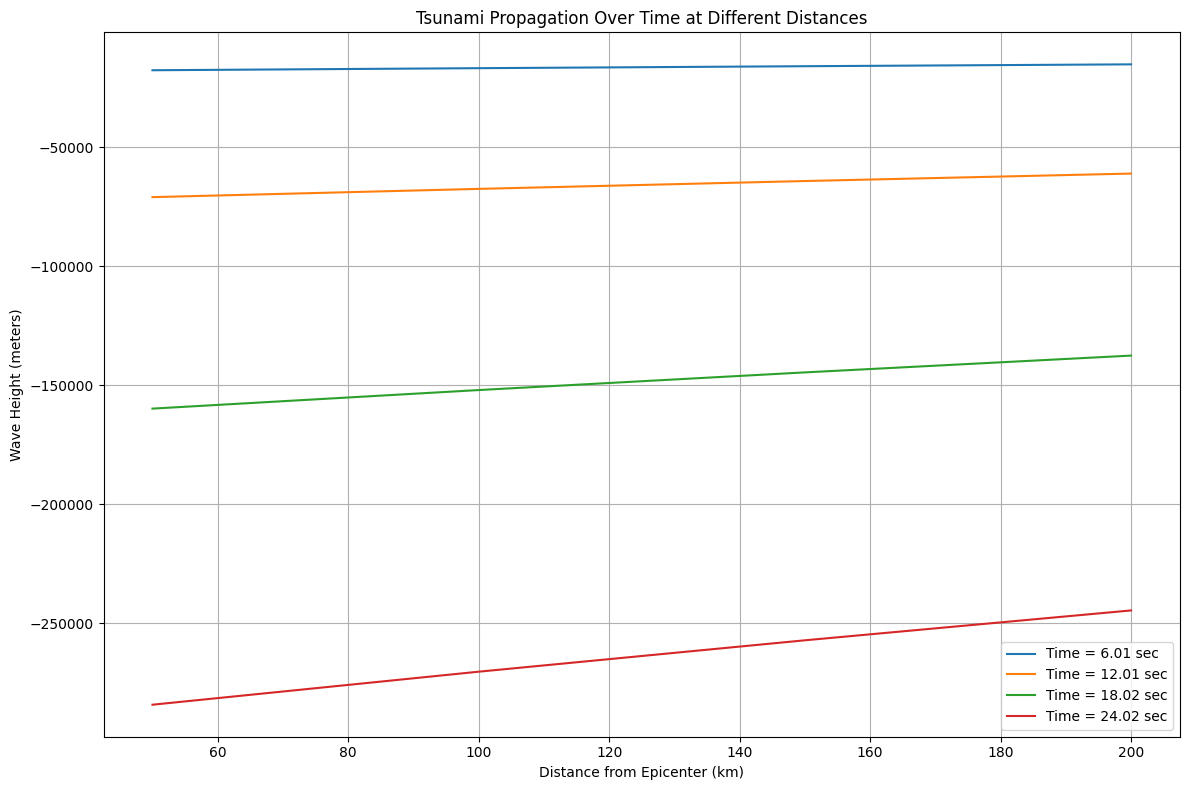

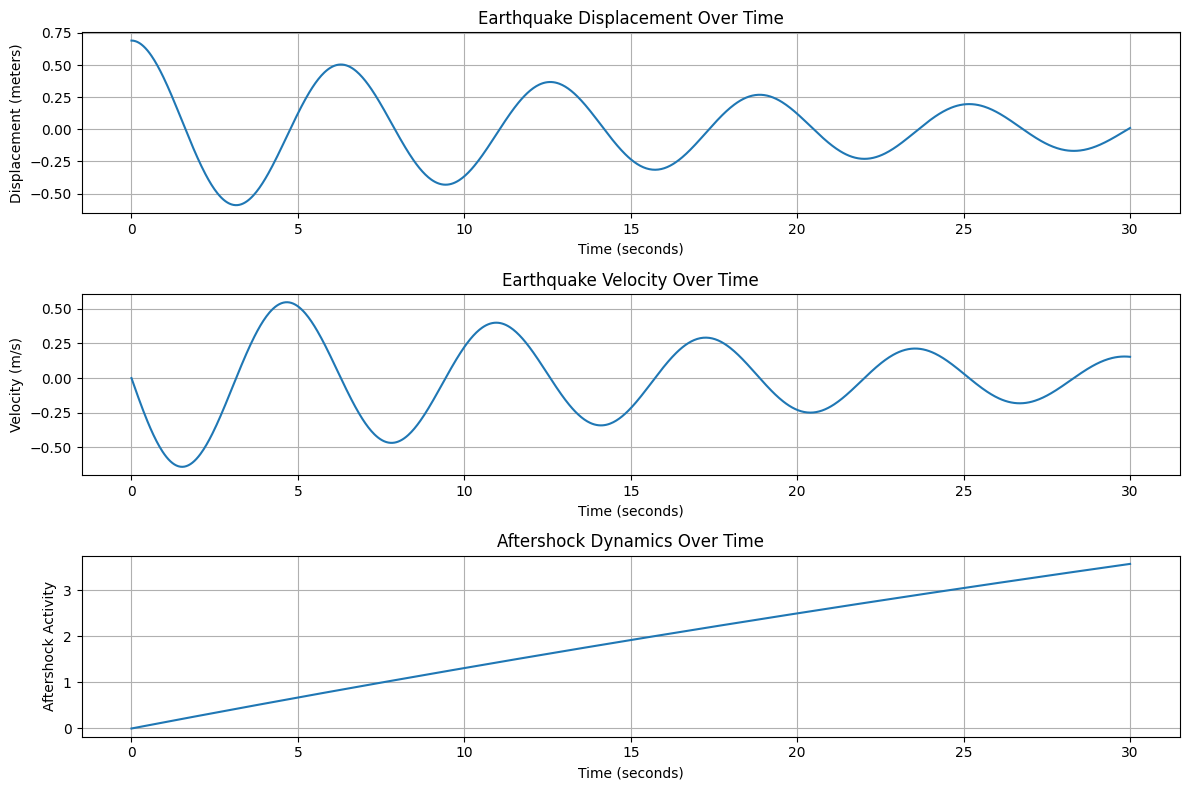

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Tsunami Model - Simulating tsunami propagation based on vertical displacement
def tsunami_model(y, t, earthquake_params):
    """
    Tsunami propagation model based on vertical seafloor displacement.
    y = [wave_height, wave_velocity]
    """
    displacement = earthquake_params["displacement"]  # estimated seafloor displacement (m)
    tsunami_speed = 1500  # approximate tsunami wave speed in deep water (m/s)

    dydt = [y[1], -tsunami_speed * displacement]  # simplified propagation model
    return dydt


# Earthquake Model based on Elastic Rebound Theory (simplified)
def earthquake_model(y, t, magnitude, depth, location):
    """
    Simple ODE model for earthquake dynamics (damped harmonic oscillator).
    y = [displacement, velocity]
    """
    x, v = y

    gamma = 0.1   # damping coefficient
    lambda_ = 1.0 # restoring force constant

    dxdt = v
    dvdt = -gamma * v - lambda_ * x
    return [dxdt, dvdt]


# Aftershock Model based on an Omori-style decay (simplified)
def aftershock_model(N, t, alpha, beta, S):
    """
    ODE model of aftershock activity.
    N = aftershock activity level (arbitrary units)
    """
    dNdt = alpha * S - beta * N
    return dNdt


def get_input():
    print("Please enter the following parameters for the earthquake simulation:")

    magnitude = float(input("Enter the magnitude of the earthquake (e.g., 6.9): "))
    depth = float(input("Enter the depth of the earthquake (in km, e.g., 10): "))

    lat = float(input("Enter latitude of the earthquake (e.g., 23.7): "))
    lon = float(input("Enter longitude of the earthquake (e.g., 121.0): "))
    location = (lat, lon)

    displacement = magnitude * 0.1  # simple estimation based on magnitude
    alpha = float(input("Enter the aftershock rate constant alpha (e.g., 0.1): "))
    beta = float(input("Enter the aftershock decay constant beta (e.g., 0.01): "))

    time_span = float(input("Enter the time span for the simulation in seconds (e.g., 30): "))

    return magnitude, depth, location, displacement, alpha, beta, time_span


def main():
    magnitude, depth, location, displacement, alpha, beta, time_span = get_input()

    # Initial conditions
    y0_earthquake = [displacement, 0.0]  # [initial displacement, initial velocity]

    # Time vector
    t = np.linspace(0, time_span, 1000)

    # Earthquake ODE solve
    solution = odeint(earthquake_model, y0_earthquake, t, args=(magnitude, depth, location))

    # Aftershock ODE solve
    S_initial = magnitude * 0.2
    aftershock_solution = odeint(aftershock_model, 0.0, t, args=(alpha, beta, S_initial)).flatten()

    # Tsunami ODE solve
    tsunami_solution = odeint(
        tsunami_model,
        [displacement, 0.0],
        t,
        args=({"displacement": displacement, "depth": depth},)
    )

    # Tsunami impact simulation over distance (km)
    distances_from_epicenter = [50, 100, 150, 200]

    # Plot tsunami propagation at different times
    plt.figure(figsize=(12, 8))

    # Make sure these indices exist even if time_span is small
    time_indices = [200, 400, 600, 800]
    time_indices = [idx for idx in time_indices if idx < len(t)]

    for idx in time_indices:
        wave_heights = [tsunami_solution[idx, 0] * np.exp(-d / 1000.0) for d in distances_from_epicenter]
        plt.plot(distances_from_epicenter, wave_heights, label=f"Time = {t[idx]:.2f} sec")

    plt.xlabel("Distance from Epicenter (km)")
    plt.ylabel("Wave Height (meters)")
    plt.title("Tsunami Propagation Over Time at Different Distances")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot earthquake displacement, velocity, and aftershock dynamics
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(t, solution[:, 0], label="Displacement (m)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Displacement (meters)")
    plt.title("Earthquake Displacement Over Time")
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(t, solution[:, 1], label="Velocity (m/s)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Velocity (m/s)")
    plt.title("Earthquake Velocity Over Time")
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(t, aftershock_solution, label="Aftershocks")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Aftershock Activity")
    plt.title("Aftershock Dynamics Over Time")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
